In [1]:
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')
#Mertics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

%matplotlib inline

c:\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [14]:
#Convert string timestamp format to timestamp
## https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
data = pd.read_csv("AirPassengers.csv", index_col= 'Month')
data.index = pd.to_datetime(data.index, format="%Y-%m")


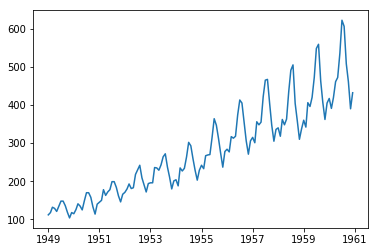

In [18]:
plt.plot(data)

### Decide Metric 

* **R squared**, coefficient of determination (in econometrics it can be interpreted as a percentage of variance explained by the model)
* **Mean Absolute Error** it is an interpretable metric because it has the same unit of measurement as the initial series
* Median Absolute Error, again an interpretable metric, particularly interesting because it is robust to outliers
* Mean Squared Error, most commonly used, gives higher penalty to big mistakes and vise versa
* Mean Squared Logarithmic Error, practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends
* Mean Absolute Percentage Error, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management

In [19]:
#Calculate Mean Absolute Percentage
def mean_absolute_percentage_error(y_true, y_pred):
    return (100 * np.sum(np.abs(y_true - y_pred)))/len(y_true)
    

**Baseline 1 - Moving Average**
Follows that today is prediction the mean of the previous days value

In [ ]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    np.avg(series[-n:])